In [2]:
import numpy as np

def n_body(t,x,p):
    """
    ODE function for the n-body problem.

    Parameters:
    t (float): time (unused but required for ODE solver compatibility)
    x (np.array): state vector containing positions and velocities
    p (dict): parameters dictionary containing:
        - m (list): masses of particles
        - G (float): gravitational constant
        - dimension (int): number of spatial dimensions
        - fix_first (bool): whether to fix the first particle in place

    Returns:
    np.array: derivative of state vector (velocities and accelerations)
    """
    # Extract parameters
    masses = np.array(p['m'])
    G = p['G']
    dimensions = p['dimension']
    n_bodies = len(masses)

    # Initialize derivative vector
    dxdt = np.zeros_like(x)

    # First half of dxdt is just the velocities from second half of x
    dxdt[:n_bodies*dimensions] = x[n_bodies*dimensions:]  # n_bodies = 3, dimensions = 2; dxdt[0:6] = x[6:12]

    # Initialize force matrices for each dimension
    force_matrices = np.zeros((dimensions, n_bodies, n_bodies))

    # Calculate forces between all pairs of bodies
    for i in range(n_bodies):
        for j in range(i+1, n_bodies):  # Only upper triangle

            # Calculate displacement vector between bodies i and j
            r_ij = []  # x, y
            for d in range(dimensions):
                displacement = x[i*dimensions + d] - x[j*dimensions + d]
                # print(f"Displacement between body {i} and body {j} in dimension {d}: {displacement}")
                r_ij.append(displacement)

            r_ij = np.array(r_ij)  # x, y displacement

            # Calculate distance
            r = np.sqrt(np.sum(r_ij**2))
            # print(f"Distance between body {i} and body {j}: {r}")

            # Calculate gravitational force magnitude
            force_mag = -G * masses[i] * masses[j] / (r**3)
            # print(f"Force magnitude between body {i} and body {j}: {force_mag}")

            # Calculate force components and fill force matrices
            for d in range(dimensions):
                force_matrices[d][i,j] = force_mag * r_ij[d]
                force_matrices[d][j,i] = -force_matrices[d][i,j]  # Fill in lower triangle

    # print("Force matrix x:")
    # print(force_matrices[0])
    # print("Force matrix y:")
    # print(force_matrices[1])

    # Sum forces on each body and calculate accelerations
    for i in range(n_bodies):
        if p.get('fix_first', False) and i == 0:
            # If fix_first is True, first body doesn't move
            continue

        # Calculate acceleration components for each dimension
        for d in range(dimensions):
            # print(force_matrices[d][i])
            total_force = np.sum(force_matrices[d][i])
            dxdt[n_bodies*dimensions + i*dimensions + d] = total_force / masses[i]  # vx1, vy1, vx2, vy2, vx3, vy3, [ax1, ay1,] ax2, ay2, ax3, ay3

    return dxdt


Part (a): Finding various elliptical orbits

Simulating Circular Orbit


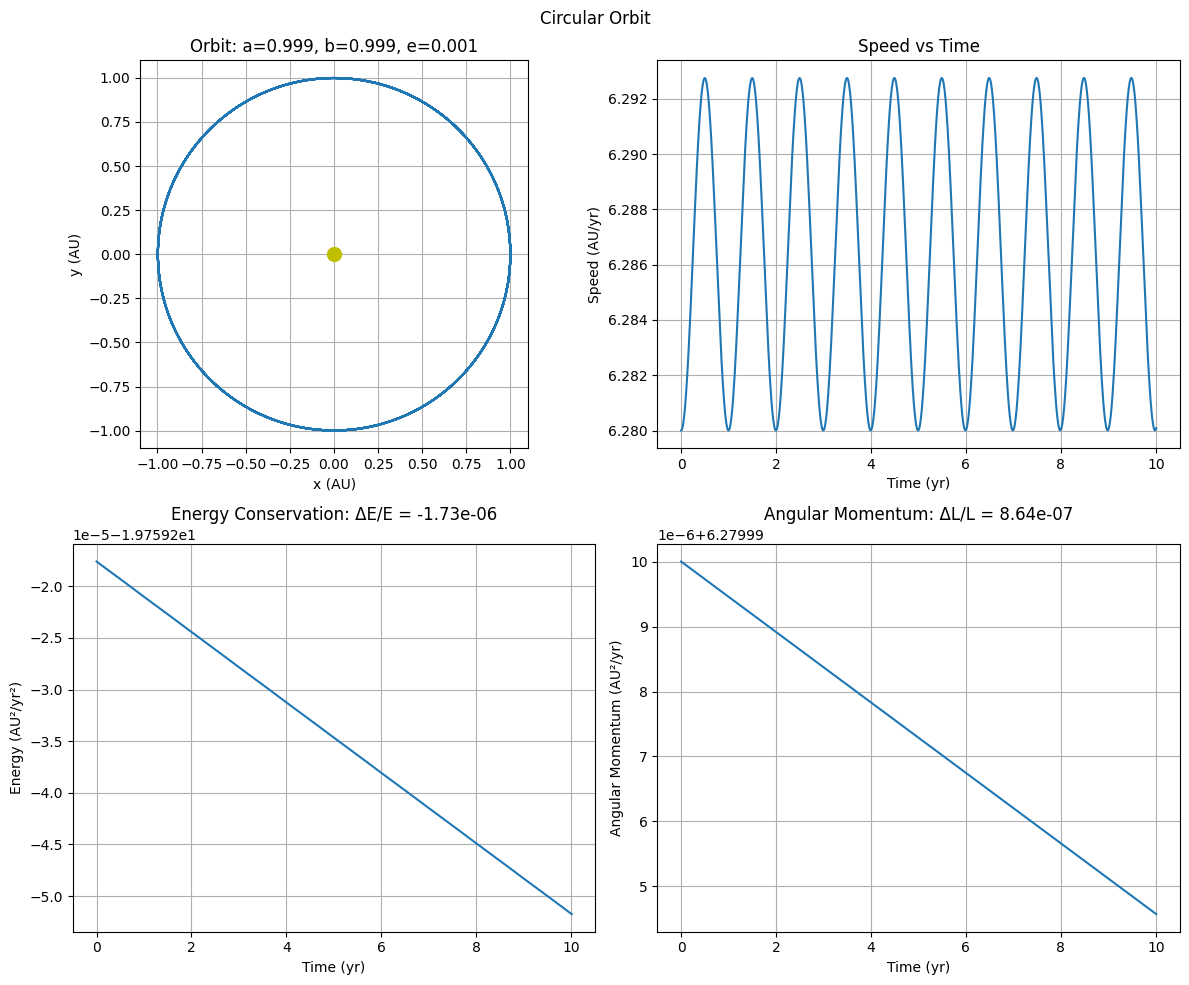

Orbital Parameters:
Semi-major axis (a): 0.998986 AU
Semi-minor axis (b): 0.998985 AU
Eccentricity (e): 0.001014
Energy: -19.759252 AU²/yr²
Angular Momentum: 6.279995 AU²/yr

Simulating Elliptical Orbit #1 (higher velocity)


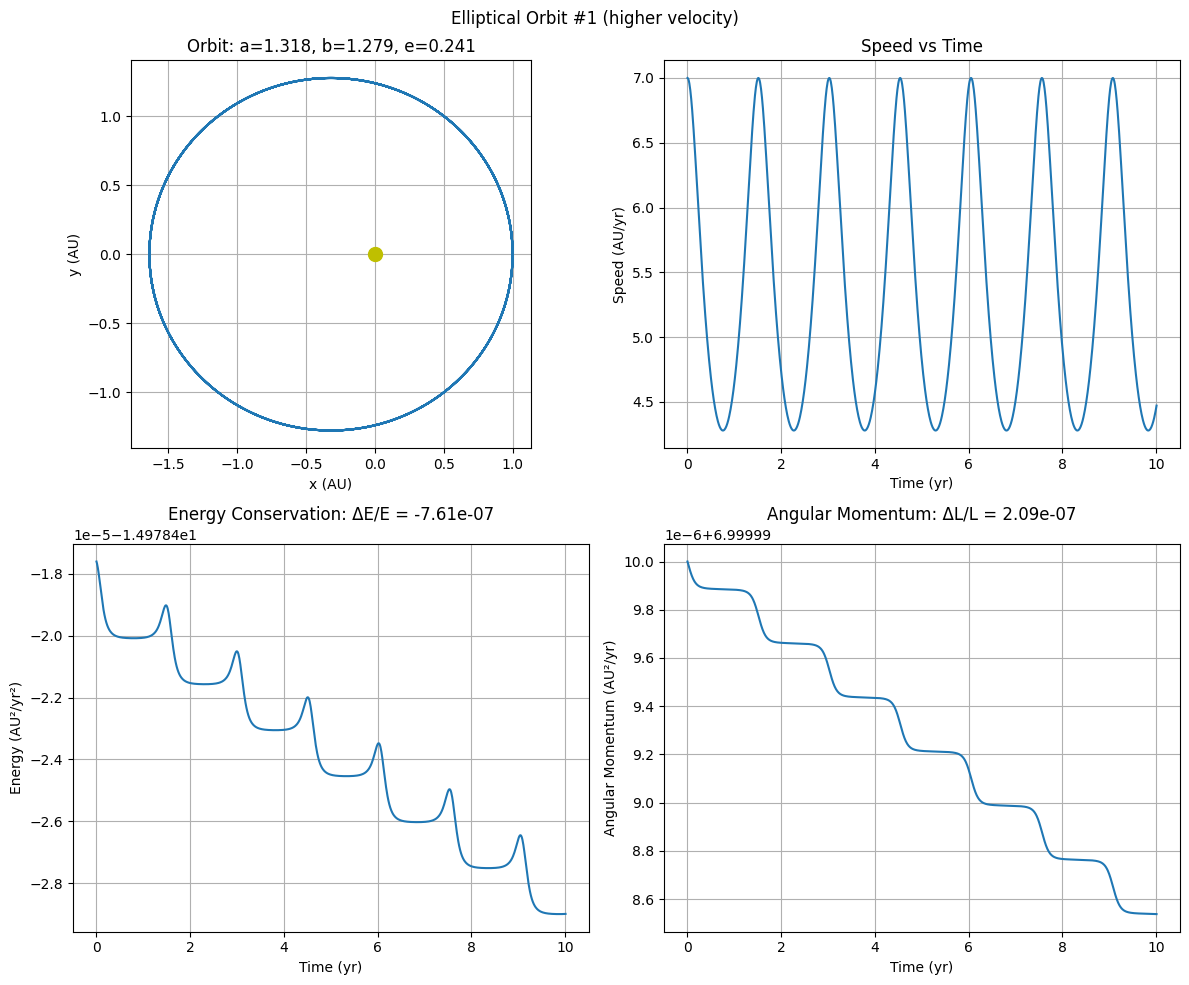

Orbital Parameters:
Semi-major axis (a): 1.317842 AU
Semi-minor axis (b): 1.278939 AU
Eccentricity (e): 0.241184
Energy: -14.978429 AU²/yr²
Angular Momentum: 6.999999 AU²/yr

Simulating Elliptical Orbit #2 (lower velocity)


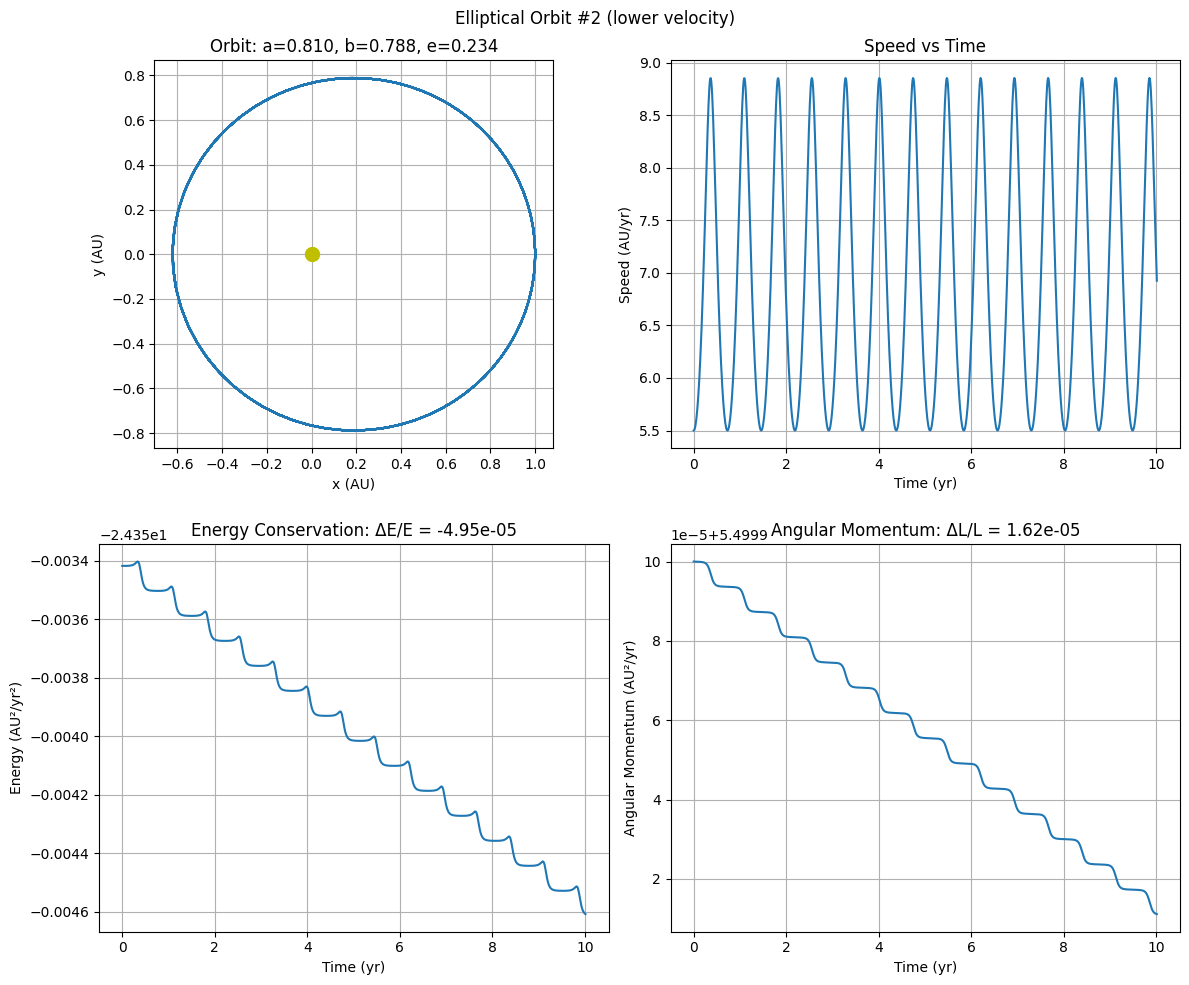

Orbital Parameters:
Semi-major axis (a): 0.810492 AU
Semi-minor axis (b): 0.788043 AU
Eccentricity (e): 0.233725
Energy: -24.354608 AU²/yr²
Angular Momentum: 5.499911 AU²/yr

Verifying Kepler's Second Law for this orbit:


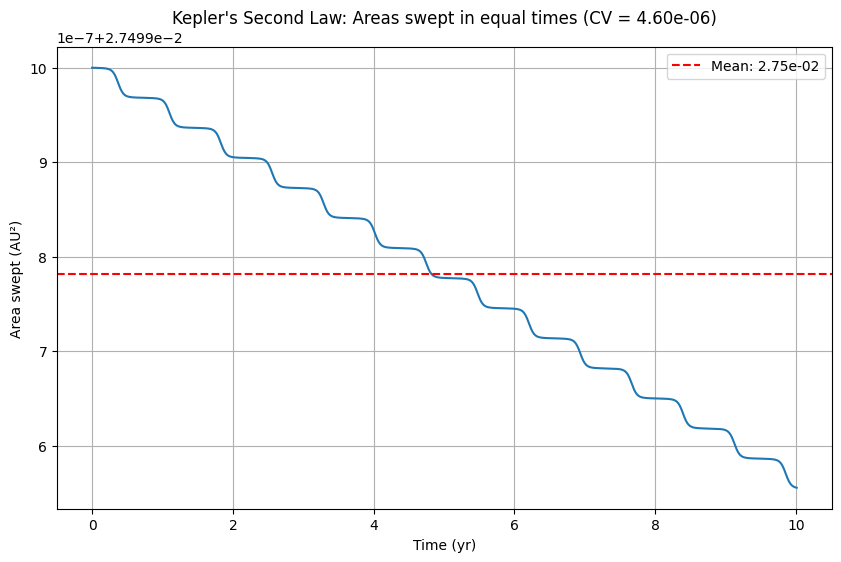

Kepler's Second Law Analysis:
Mean area swept per time step: 2.749978e-02 AU²
Standard deviation: 1.264194e-07 AU²
Coefficient of variation: 4.597107e-06
This small variation confirms Kepler's Second Law: equal areas in equal times

Simulating Elliptical Orbit #3 (larger radius)


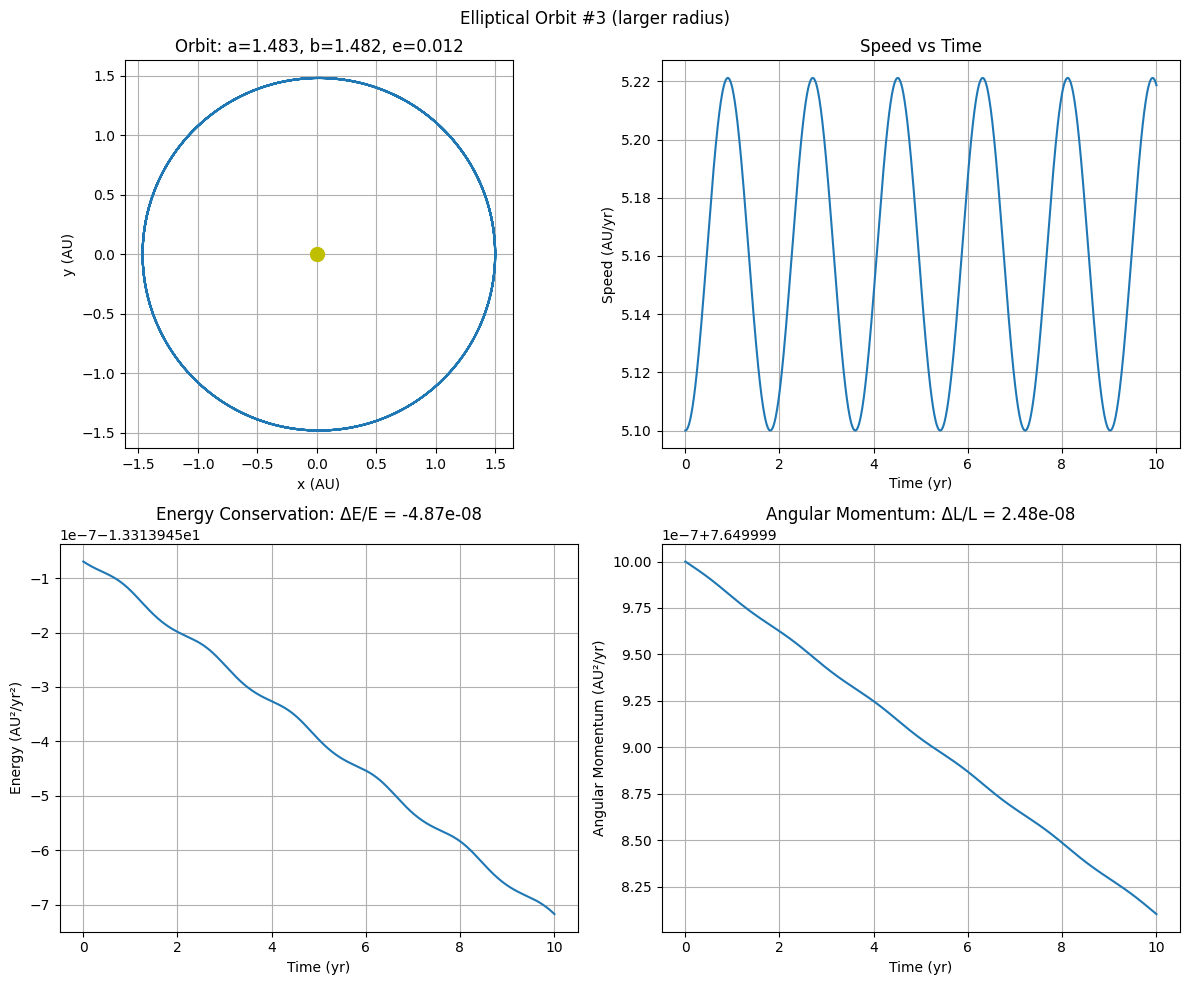

Orbital Parameters:
Semi-major axis (a): 1.482596 AU
Semi-minor axis (b): 1.482494 AU
Eccentricity (e): 0.011739
Energy: -13.313946 AU²/yr²
Angular Momentum: 7.650000 AU²/yr

Simulating Elliptical Orbit #4 (even larger radius)


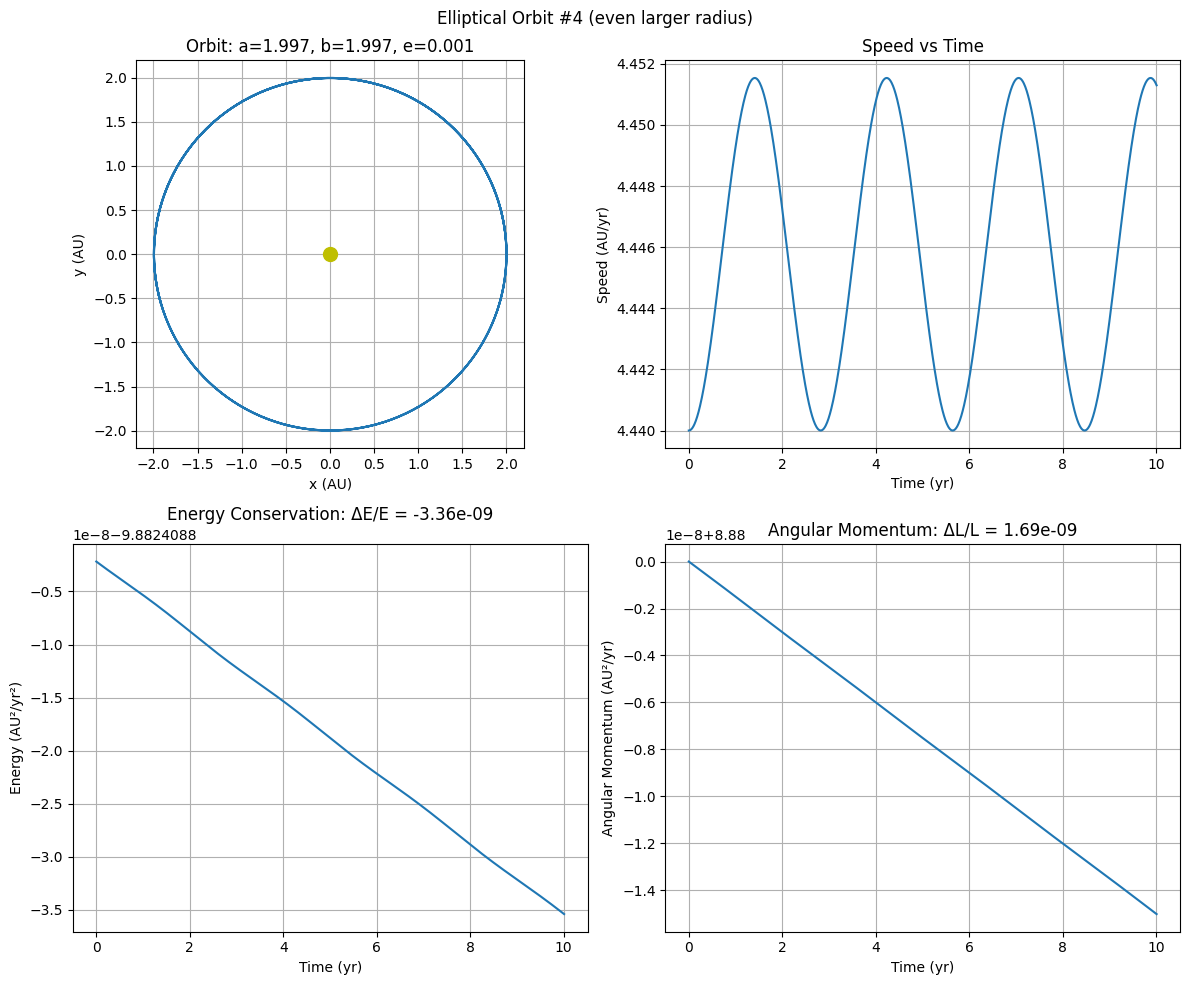

Orbital Parameters:
Semi-major axis (a): 1.997409 AU
Semi-minor axis (b): 1.997407 AU
Eccentricity (e): 0.001297
Energy: -9.882409 AU²/yr²
Angular Momentum: 8.880000 AU²/yr

Part (b): Verifying Kepler's Third Law


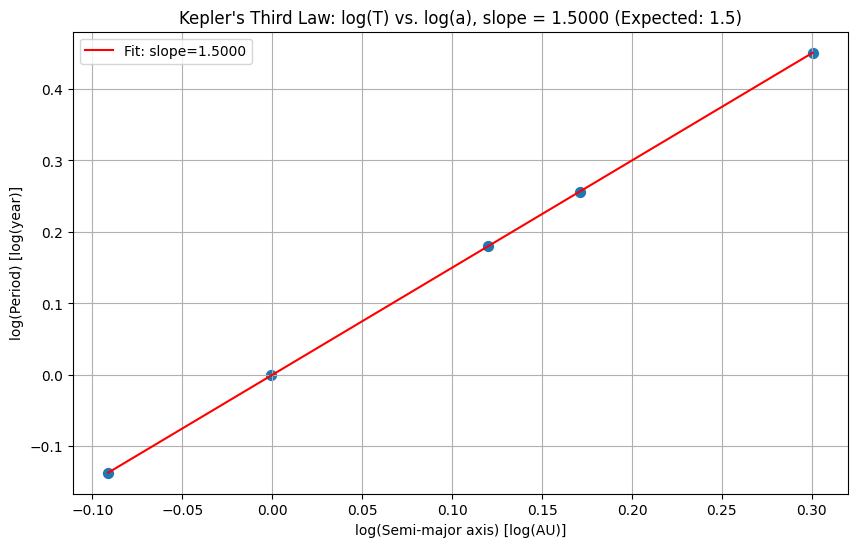

Kepler's Third Law Analysis:
Measured slope: 1.500000 (Expected: 1.5)
Correlation coefficient: 1.000000

T²/a³ ratios for each orbit:
Orbit 1: 1.000000
Orbit 2: 1.000000
Orbit 3: 1.000000
Orbit 4: 1.000000
Orbit 5: 1.000000
Average ratio: 1.000000
This should equal 4π²/GM = 1.000000 = 1.0

Part (c): Finding the second focus
For Elliptical Orbit #1 (higher velocity):
The Sun is at one focus (0, 0)
The second focus is at (-0.635685, 0)
For any point on the ellipse, the sum of distances to both foci should equal 2a = 2.635685

Part (d): Kepler's Second Law
The analysis above for Elliptical Orbit #2 confirms Kepler's Second Law
Equal areas are swept out in equal times, which corresponds to conservation of angular momentum


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from ode_solver import Euler, EulerCromer, EulerRichardson, RungeKutta, solve_ode

# Define a simplified two-body central force function for planetary motion
def planet_motion(t, state, params):
    """
    Simplified ODE function for a central force (for a planet orbiting a fixed sun)

    Parameters:
    t (float): time (unused but required for ODE solver)
    state (np.array): [x, y, vx, vy] state vector
    params (tuple): (G*M,) gravitational parameter

    Returns:
    np.array: derivative of state vector [vx, vy, ax, ay]
    """
    x, y, vx, vy = state
    GM = params

    # Calculate distance
    r = np.sqrt(x**2 + y**2)
    r3 = r**3

    # Calculate accelerations
    ax = -GM * x / r3
    ay = -GM * y / r3

    # Return derivatives [vx, vy, ax, ay]
    return np.array([vx, vy, ax, ay])

# Calculate energy for the central force problem
def calculate_energy(state, GM):
    """Calculate total energy (per unit mass)"""
    x, y, vx, vy = state
    r = np.sqrt(x**2 + y**2)

    # Kinetic + Potential energy
    KE = 0.5 * (vx**2 + vy**2)
    PE = -GM / r

    return KE + PE

# Calculate angular momentum (per unit mass)
def calculate_angular_momentum(state):
    """Calculate angular momentum (per unit mass)"""
    x, y, vx, vy = state
    return x*vy - y*vx

# Calculate area swept in one time step
def calculate_area_swept(state1, state2, dt):
    """Calculate area swept by radius vector in one time step"""
    x1, y1 = state1[0], state1[1]
    x2, y2 = state2[0], state2[1]

    # Approximation of area swept
    area = 0.5 * abs(x1*vy1 - y1*vx1) * dt
    return area

# Find orbital parameters
def find_orbital_parameters(y, GM):
    """Find semi-major axis, eccentricity, etc."""
    # Take the latest state
    state = y[-1]

    # Calculate energy and angular momentum
    energy = calculate_energy(state, GM)
    L = calculate_angular_momentum(state)

    # Calculate semi-major axis from energy
    a = -GM / (2 * energy)

    # Calculate eccentricity
    e = np.sqrt(1 + 2 * energy * L**2 / GM**2)

    # Calculate semi-minor axis
    b = a * np.sqrt(1 - e**2)

    return a, b, e, L

# Function to run a single orbit simulation
def simulate_orbit(x0, y0, vx0, vy0, GM=4*np.pi**2, dt=0.01, method=RungeKutta, t_max=10):
    """Run a simulation of an orbit and return results"""
    initial_state = np.array([x0, y0, vx0, vy0])
    t_span = [0, t_max]

    # Solve the ODE
    t, y = solve_ode(planet_motion, t_span, initial_state, method, GM, first_step=dt)

    return t, y

# Plot an orbit and analyze its properties
def plot_orbit(t, y, GM=4*np.pi**2, title="Orbit"):
    """Plot an orbit and analyze its properties"""
    # Extract position data
    x = y[:, 0]
    y_pos = y[:, 1]

    # Calculate speeds
    vx = y[:, 2]
    vy = y[:, 3]
    speeds = np.sqrt(vx**2 + vy**2)

    # Calculate energies
    energies = np.array([calculate_energy(state, GM) for state in y])

    # Calculate angular momenta
    angular_momenta = np.array([calculate_angular_momentum(state) for state in y])

    # Calculate orbital parameters
    a, b, e, L = find_orbital_parameters(y, GM)

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    # Plot the orbit
    ax1.plot(x, y_pos)
    ax1.plot(0, 0, 'yo', markersize=10)  # Sun at origin
    ax1.set_xlabel('x (AU)')
    ax1.set_ylabel('y (AU)')
    ax1.set_title(f'Orbit: a={a:.3f}, b={b:.3f}, e={e:.3f}')
    ax1.grid(True)
    ax1.set_aspect('equal')

    # Plot speed vs. time
    ax2.plot(t, speeds)
    ax2.set_xlabel('Time (yr)')
    ax2.set_ylabel('Speed (AU/yr)')
    ax2.set_title('Speed vs Time')
    ax2.grid(True)

    # Plot energy vs. time
    ax3.plot(t, energies)
    ax3.set_xlabel('Time (yr)')
    ax3.set_ylabel('Energy (AU²/yr²)')
    ax3.set_title(f'Energy Conservation: ΔE/E = {(max(energies)-min(energies))/np.mean(energies):.2e}')
    ax3.grid(True)

    # Plot angular momentum vs. time
    ax4.plot(t, angular_momenta)
    ax4.set_xlabel('Time (yr)')
    ax4.set_ylabel('Angular Momentum (AU²/yr)')
    ax4.set_title(f'Angular Momentum: ΔL/L = {(max(angular_momenta)-min(angular_momenta))/np.mean(angular_momenta):.2e}')
    ax4.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # Print orbital info
    print(f"Orbital Parameters:")
    print(f"Semi-major axis (a): {a:.6f} AU")
    print(f"Semi-minor axis (b): {b:.6f} AU")
    print(f"Eccentricity (e): {e:.6f}")
    print(f"Energy: {energies[-1]:.6f} AU²/yr²")
    print(f"Angular Momentum: {L:.6f} AU²/yr")

    return a, b, e, L

# Verify Kepler's second law
def verify_keplers_second_law(t, y, GM=4*np.pi**2):
    """Verify Kepler's second law"""
    dt = t[1] - t[0]

    # Calculate areas swept in each time step (using angular momentum)
    areas = []
    for i in range(len(t)):
        L = calculate_angular_momentum(y[i])
        area_rate = 0.5 * L  # Area swept per unit time
        areas.append(area_rate * dt)

    # Calculate statistics
    mean_area = np.mean(areas)
    std_area = np.std(areas)

    # Plot areas
    plt.figure(figsize=(10, 6))
    plt.plot(t, areas)
    plt.axhline(mean_area, color='r', linestyle='--', label=f'Mean: {mean_area:.2e}')
    plt.xlabel('Time (yr)')
    plt.ylabel('Area swept (AU²)')
    plt.title(f"Kepler's Second Law: Areas swept in equal times (CV = {std_area/mean_area:.2e})")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Kepler's Second Law Analysis:")
    print(f"Mean area swept per time step: {mean_area:.6e} AU²")
    print(f"Standard deviation: {std_area:.6e} AU²")
    print(f"Coefficient of variation: {std_area/mean_area:.6e}")
    print(f"This small variation confirms Kepler's Second Law: equal areas in equal times")

# Verify Kepler's third law with multiple orbits
def verify_keplers_third_law(orbit_data):
    """Verify Kepler's third law using orbit data"""
    # Extract data
    semimajor_axes = []
    periods = []

    for data in orbit_data:
        semimajor_axes.append(data[0])  # a

        # Estimate period from angular momentum and semi-major axis
        a = data[0]
        periods.append(2*np.pi*a**1.5/np.sqrt(4*np.pi**2))  # T = 2π√(a³/GM)

    # Convert to log space
    log_a = np.log10(semimajor_axes)
    log_T = np.log10(periods)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(log_a, log_T)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(log_a, log_T, s=50)

    # Add fit line
    x_line = np.linspace(min(log_a), max(log_a), 100)
    y_line = slope * x_line + intercept
    plt.plot(x_line, y_line, 'r-', label=f'Fit: slope={slope:.4f}')

    plt.xlabel('log(Semi-major axis) [log(AU)]')
    plt.ylabel('log(Period) [log(year)]')
    plt.title(f"Kepler's Third Law: log(T) vs. log(a), slope = {slope:.4f} (Expected: 1.5)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Calculate T²/a³ ratios
    ratios = [T**2/a**3 for T, a in zip(periods, semimajor_axes)]

    print(f"Kepler's Third Law Analysis:")
    print(f"Measured slope: {slope:.6f} (Expected: 1.5)")
    print(f"Correlation coefficient: {r_value:.6f}")

    print("\nT²/a³ ratios for each orbit:")
    for i, ratio in enumerate(ratios):
        print(f"Orbit {i+1}: {ratio:.6f}")
    print(f"Average ratio: {np.mean(ratios):.6f}")
    print(f"This should equal 4π²/GM = {4*np.pi**2/(4*np.pi**2):.6f} = 1.0")

# Run simulations for Problem 5.3
def solve_problem_5_3():
    """Solve Problem 5.3: Verification of Kepler's second and third law"""
    # Set GM = 4π² (in AU³/year²)
    GM = 4 * np.pi**2

    # a) Find different elliptical orbits
    print("\nPart (a): Finding various elliptical orbits")

    # Test cases for different elliptical orbits
    test_cases = [
        {'x0': 1.0, 'y0': 0.0, 'vx0': 0.0, 'vy0': 6.28, 'title': "Circular Orbit"},
        {'x0': 1.0, 'y0': 0.0, 'vx0': 0.0, 'vy0': 7.0, 'title': "Elliptical Orbit #1 (higher velocity)"},
        {'x0': 1.0, 'y0': 0.0, 'vx0': 0.0, 'vy0': 5.5, 'title': "Elliptical Orbit #2 (lower velocity)"},
        {'x0': 1.5, 'y0': 0.0, 'vx0': 0.0, 'vy0': 5.1, 'title': "Elliptical Orbit #3 (larger radius)"},
        {'x0': 2.0, 'y0': 0.0, 'vx0': 0.0, 'vy0': 4.44, 'title': "Elliptical Orbit #4 (even larger radius)"}
    ]

    # Store results for analysis
    orbit_results = []

    # Run simulations for each test case
    for test in test_cases:
        print(f"\nSimulating {test['title']}")
        t, y = simulate_orbit(
            test['x0'], test['y0'], test['vx0'], test['vy0'],
            GM=GM, dt=0.01, method=RungeKutta, t_max=10
        )

        # Analyze and plot results
        a, b, e, L = plot_orbit(t, y, GM=GM, title=test['title'])
        orbit_results.append((a, b, e, L))

        # Check Kepler's second law for one of the elliptical orbits
        if test['title'] == "Elliptical Orbit #2 (lower velocity)":
            print("\nVerifying Kepler's Second Law for this orbit:")
            verify_keplers_second_law(t, y, GM=GM)

    # b) Verify Kepler's third law
    print("\nPart (b): Verifying Kepler's Third Law")
    verify_keplers_third_law(orbit_results)

    # c) Find the second focus
    print("\nPart (c): Finding the second focus")
    # Take one of the elliptical orbits
    orbit_idx = 1  # Elliptical Orbit #1
    a, b, e, _ = orbit_results[orbit_idx]
    c = a * e  # Distance from center to focus

    print(f"For {test_cases[orbit_idx]['title']}:")
    print(f"The Sun is at one focus (0, 0)")
    print(f"The second focus is at ({-2*c:.6f}, 0)")
    print(f"For any point on the ellipse, the sum of distances to both foci should equal 2a = {2*a:.6f}")

    # d) Address equal areas in equal times
    print("\nPart (d): Kepler's Second Law")
    print("The analysis above for Elliptical Orbit #2 confirms Kepler's Second Law")
    print("Equal areas are swept out in equal times, which corresponds to conservation of angular momentum")

# Run the solution
solve_problem_5_3()